In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from comet_ml import Experiment
from ipywidgets import interact, IntSlider

from src.data.dataset import split_dataset, tidy_plays_df
from src.data.data_query import StorageEngine
from src.data.plays_model import game_json_to_plays_list
from src.features.features import basic_features, advanced_features, normalize_plays_coords
#from src.models.xgboost import train_xgb

In [2]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [135]:
from sklearn import metrics
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
import pickle

In [4]:
df = pd.read_csv("./data/processed/plays_2015-2020.csv", index_col=False)
advanced_df = advanced_features(df)
advanced_df.head()

,seconds_elapsed,period_idx,x_coord,y_coord,x_coord_norm,y_coord_norm,dist_from_net,angle_from_net,Backhand,Deflected,...,SHOT,STOP,TAKEAWAY,previous_x_coord,previous_y_coord,seconds_from_previous,dist_from_previous,rebound,angle_change,speed
0,33.0,1,-83.0,13.0,83.0,-13.0,14.317821,-65.224859,0,0,...,0,0,0,0.0,0.0,33.0,84.011904,0,0.000000,2.545815
1,96.0,1,-34.0,2.0,34.0,-2.0,55.036352,-2.082565,0,0,...,0,0,0,-69.0,-22.0,18.0,42.438190,0,0.000000,2.357677
2,174.0,1,-57.0,-29.0,57.0,29.0,43.185646,42.184443,0,0,...,0,0,0,-97.0,-5.0,1.0,46.647615,0,0.000000,46.647615
3,221.0,1,61.0,4.0,61.0,4.0,28.284271,8.130102,0,0,...,0,0,0,88.0,-39.0,14.0,50.774009,0,0.000000,3.626715
4,240.0,1,64.0,7.0,64.0,7.0,25.961510,15.642246,0,0,...,1,0,0,61.0,4.0,19.0,4.242641,1,7.512144,0.223297


In [145]:
df.columns

Index(['event_idx', 'event_type_id', 'period_idx', 'period_type', 'game_time',
       'period_time', 'shot_type', 'team_initiative_id',
       'team_initiative_name', 'x_coord', 'y_coord', 'shooter_id',
       'shooter_name', 'goalie_id', 'goalie_name', 'strength',
       'empty_net_bool', 'previous_event_idx', 'previous_event_period',
       'previous_event_period_time', 'previous_event_time',
       'previous_event_type', 'previous_event_x_coord',
       'previous_event_y_coord', 'gamePk', 'game_season', 'game_type',
       'game_start_time', 'x_coord_norm', 'y_coord_norm', 'angle_from_net',
       'rebound', 'previous_event_x_coord_norm', 'previous_event_y_coord_norm',
       'angle_change', 'is_goal'],
      dtype='object')

In [148]:
df[df['gamePk']==2017021065][]

244391     Snap Shot
244392    Wrist Shot
244393      Backhand
244394     Slap Shot
244395    Wrist Shot
             ...    
244457     Snap Shot
244458     Slap Shot
244459     Slap Shot
244460    Wrist Shot
244461    Wrist Shot
Name: shot_type, Length: 71, dtype: object

In [150]:
advanced_df.head()

,seconds_elapsed,period_idx,x_coord,y_coord,x_coord_norm,y_coord_norm,dist_from_net,angle_from_net,Backhand,Deflected,...,SHOT,STOP,TAKEAWAY,previous_x_coord,previous_y_coord,seconds_from_previous,dist_from_previous,rebound,angle_change,speed
0,33.0,1,-83.0,13.0,83.0,-13.0,14.317821,-65.224859,0,0,...,0,0,0,0.0,0.0,33.0,84.011904,0,0.000000,2.545815
1,96.0,1,-34.0,2.0,34.0,-2.0,55.036352,-2.082565,0,0,...,0,0,0,-69.0,-22.0,18.0,42.438190,0,0.000000,2.357677
2,174.0,1,-57.0,-29.0,57.0,29.0,43.185646,42.184443,0,0,...,0,0,0,-97.0,-5.0,1.0,46.647615,0,0.000000,46.647615
3,221.0,1,61.0,4.0,61.0,4.0,28.284271,8.130102,0,0,...,0,0,0,88.0,-39.0,14.0,50.774009,0,0.000000,3.626715
4,240.0,1,64.0,7.0,64.0,7.0,25.961510,15.642246,0,0,...,1,0,0,61.0,4.0,19.0,4.242641,1,7.512144,0.223297


In [140]:
df[['gamePk','period_idx', 'x_coord','y_coord']].head()

,gamePk,period_idx,x_coord,y_coord
0,2015010002,1,-83.0,13.0
1,2015010002,1,-34.0,2.0
2,2015010002,1,-57.0,-29.0
3,2015010002,1,61.0,4.0
4,2015010002,1,64.0,7.0


In [152]:
#df3 = pd.get_dummies(df.shot_type)
df2 = pd.get_dummies(df.period_type)
df['game_time'] = df['game_time'].astype('datetime64[ns]')
result_df = pd.concat([advanced_df, df2, df[['game_time','is_goal','gamePk']]], axis=1).round(2).fillna(0)
result_df['game_time'] = result_df['game_time'].astype('datetime64[ns]')
df['is_goal'] = np.where(df.event_type_id == "GOAL",1,0)


dff = result_df[result_df['game_time'].dt.year<=2019]
test = result_df[result_df['game_time'].dt.year>2019]
dff.drop(['game_time'],axis=1,inplace=True)
dff = dff.replace({np.nan: 0, np.inf:0, -np.inf:0})


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [160]:
df.columns

Index(['event_idx', 'event_type_id', 'period_idx', 'period_type', 'game_time',
       'period_time', 'shot_type', 'team_initiative_id',
       'team_initiative_name', 'x_coord', 'y_coord', 'shooter_id',
       'shooter_name', 'goalie_id', 'goalie_name', 'strength',
       'empty_net_bool', 'previous_event_idx', 'previous_event_period',
       'previous_event_period_time', 'previous_event_time',
       'previous_event_type', 'previous_event_x_coord',
       'previous_event_y_coord', 'gamePk', 'game_season', 'game_type',
       'game_start_time', 'x_coord_norm', 'y_coord_norm', 'angle_from_net',
       'rebound', 'previous_event_x_coord_norm', 'previous_event_y_coord_norm',
       'angle_change', 'is_goal'],
      dtype='object')

In [162]:
df['period_time']

0        1900-01-01 00:00:33
1        1900-01-01 00:01:36
2        1900-01-01 00:02:54
3        1900-01-01 00:03:41
4        1900-01-01 00:04:00
                 ...        
437690   1900-01-01 00:16:01
437691   1900-01-01 00:17:20
437692   1900-01-01 00:18:50
437693   1900-01-01 00:19:27
437694   1900-01-01 00:19:45
Name: period_time, Length: 437695, dtype: datetime64[ns]

In [159]:
result_df[result_df['gamePk']==2017021065].columns

Index(['seconds_elapsed', 'period_idx', 'x_coord', 'y_coord', 'x_coord_norm',
       'y_coord_norm', 'dist_from_net', 'angle_from_net', 'Backhand',
       'Deflected', 'Slap Shot', 'Snap Shot', 'Tip-In', 'Wrap-around',
       'Wrist Shot', 'empty_net', 'BLOCKED_SHOT', 'FACEOFF', 'GIVEAWAY',
       'GOAL', 'HIT', 'MISSED_SHOT', 'OTHER', 'PENALTY', 'PERIOD_START',
       'SHOT', 'STOP', 'TAKEAWAY', 'previous_x_coord', 'previous_y_coord',
       'seconds_from_previous', 'dist_from_previous', 'rebound',
       'angle_change', 'speed', 'OVERTIME', 'REGULAR', 'SHOOTOUT', 'game_time',
       'is_goal', 'gamePk'],
      dtype='object')

In [81]:
X_train, X_test, y_train, y_test = train_test_split(dff.drop(['is_goal','empty_net'],axis=1).fillna(0), dff['is_goal'], test_size=0.30, random_state=42)


### feature selection

In [116]:
model = LogisticRegression()
rfe = RFE(model, n_features_to_select=30, step=1)
fit = rfe.fit(X_train, y_train)
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

Num Features: 30
Selected Features: [ True  True False  True  True  True  True  True  True  True  True  True
  True  True  True False  True  True  True  True False False  True False
  True  True  True  True  True  True  True  True False  True  True False
  True]
Feature Ranking: [1 1 5 1 1 1 1 1 1 1 1 1 1 1 1 8 1 1 1 1 6 7 1 4 1 1 1 1 1 1 1 1 2 1 1 3 1]


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [117]:
feature_select = pd.DataFrame()
feature_select['features'] = X_train.columns
feature_select['RFE_select'] = fit.support_

In [124]:
model = RandomForestClassifier(random_state = 42)
rfe = RFE(model, n_features_to_select=30, step=1)
fit = rfe.fit(X_train, y_train)
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))

Num Features: 30
Selected Features: [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True False  True  True False False False
  True False  True  True  True  True  True  True  True  True False  True
 False]
Feature Ranking: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 6 1 1 7 4 8 1 5 1 1 1 1 1 1 1 1 2 1 3]


In [125]:
feature_select['RFE_random_forest'] = fit.support_

In [126]:
feature_select['select'] = np.where((feature_select['RFE_select']==True)&(feature_select['RFE_select']==True),1,0)

In [127]:
features = feature_select[feature_select['select']==1]['features'].tolist()

In [120]:
X_train.columns

Index(['seconds_elapsed', 'period_idx', 'x_coord', 'y_coord', 'x_coord_norm',
       'y_coord_norm', 'dist_from_net', 'angle_from_net', 'Backhand',
       'Deflected', 'Slap Shot', 'Snap Shot', 'Tip-In', 'Wrap-around',
       'Wrist Shot', 'BLOCKED_SHOT', 'FACEOFF', 'GIVEAWAY', 'GOAL', 'HIT',
       'MISSED_SHOT', 'OTHER', 'PENALTY', 'PERIOD_START', 'SHOT', 'STOP',
       'TAKEAWAY', 'previous_x_coord', 'previous_y_coord',
       'seconds_from_previous', 'dist_from_previous', 'rebound',
       'angle_change', 'speed', 'OVERTIME', 'REGULAR', 'SHOOTOUT'],
      dtype='object')

In [26]:
from xverse.transformer import WOE
clf = WOE()
clf.fit(X_train, y_train)

ValueError: The input feature(s) should be numeric type. Some of the input features                             has character values in it. Please use a encoder before performing monotonic operations.

In [ ]:
## cross validation

In [94]:
## MLP
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train[features], y_train)
print(classification_report(y_test, clf.predict(X_test[features])))
print(classification_report(y_train, clf.predict(X_train[features])))
##Light gbm

              precision    recall  f1-score   support

           0       0.91      1.00      0.95    108525
           1       0.49      0.03      0.05     11282

    accuracy                           0.91    119807
   macro avg       0.70      0.51      0.50    119807
weighted avg       0.87      0.91      0.87    119807

              precision    recall  f1-score   support

           0       0.91      1.00      0.95    253000
           1       0.51      0.03      0.06     26548

    accuracy                           0.91    279548
   macro avg       0.71      0.51      0.50    279548
weighted avg       0.87      0.91      0.87    279548



In [133]:
## Random forest
randomForest = RandomForestClassifier(random_state = 42, max_depth=6, class_weight = {0: 0.2, 1: 0.8}).fit(X_train[features], y_train)
print(classification_report(y_test, randomForest.predict(X_test[features])))
print(classification_report(y_train, randomForest.predict(X_train[features])))


              precision    recall  f1-score   support

           0       0.92      0.96      0.94    108525
           1       0.32      0.18      0.23     11282

    accuracy                           0.89    119807
   macro avg       0.62      0.57      0.59    119807
weighted avg       0.86      0.89      0.87    119807

              precision    recall  f1-score   support

           0       0.92      0.96      0.94    253000
           1       0.31      0.18      0.23     26548

    accuracy                           0.88    279548
   macro avg       0.62      0.57      0.58    279548
weighted avg       0.86      0.88      0.87    279548



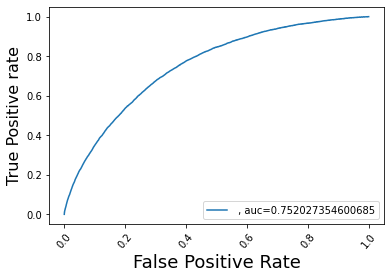

In [96]:

y_pred_proba = clf.predict_proba(X_test[features])[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label=" , auc="+str(auc))
plt.legend(loc=4)
plt.xticks(rotation=50)
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive rate', fontsize=16)
plt.show()

In [130]:
model = LGBMClassifier(class_weight={0: 0.2, 1: 0.8}, metric='auc',
               min_gain_to_split=0.3, objective='binary',)
# model = LGBMClassifier(class_weight={0: 0.2, 1: 0.8}, metric='auc',
#                min_gain_to_split=0.3, objective='binary', random_state=42,)
#                #reg_alpha=0.4, reg_lambda=1)
model.fit(X_train[features], y_train)
ypred = model.predict(X_test[features])
y_tr_pred = model.predict(X_train[features])


[LightGBM] [Warning] min_gain_to_split is set=0.3, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.3


In [112]:
feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':features}).sort_values(by="Value",ascending=False)

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


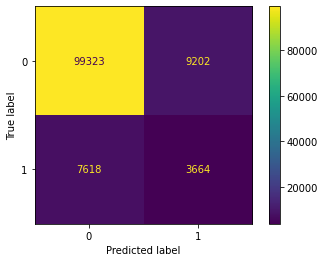

In [113]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model, X_test[features], y_test)

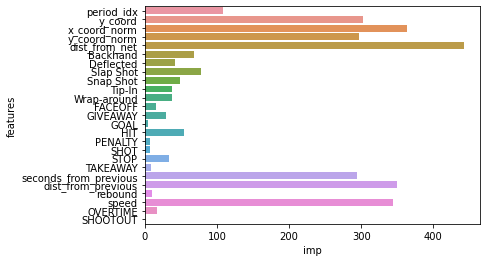

In [114]:
feature_imp = pd.DataFrame()
feature_imp['features'] = features
feature_imp['imp'] = model.feature_importances_

ax = sns.barplot(x="imp", y="features", data=feature_imp)

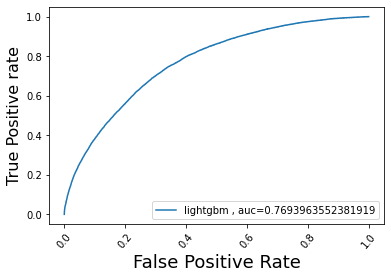

In [131]:
y_pred_proba = model.predict_proba(X_test[features])[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="lightgbm , auc="+str(auc))
plt.legend(loc=4)
plt.xticks(rotation=50)
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive rate', fontsize=16)
plt.show()

In [132]:
print('test')
print(classification_report(y_test, model.predict(X_test[features])))
print('train')
print(classification_report(y_train, model.predict(X_train[features])))

test
              precision    recall  f1-score   support

           0       0.93      0.92      0.92    108525
           1       0.30      0.34      0.32     11282

    accuracy                           0.86    119807
   macro avg       0.62      0.63      0.62    119807
weighted avg       0.87      0.86      0.87    119807

train
              precision    recall  f1-score   support

           0       0.93      0.92      0.93    253000
           1       0.32      0.35      0.33     26548

    accuracy                           0.87    279548
   macro avg       0.62      0.64      0.63    279548
weighted avg       0.87      0.87      0.87    279548



In [ ]:
### Hyperparameter tuning with 5 cross validation

In [109]:
##Lightgbm
mdl = LGBMClassifier(objective="binary" ,class_weight={0:0.2,1:0.8,},
                       metric="auc", random_state=42,
                     #n_estimators=500  
                       #min_split_gain = 23
                      )
param1 = {'min_gain_to_split':[0.1, 0.3, 0.5, 0.6],"reg_alpha" :[0.4, 1],
"reg_lambda" : [0.7, 1],}
clf = RandomizedSearchCV(mdl, param1, random_state=42, cv=5)

clf.fit(X_train[features], y_train)

[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGBM] [Warning] min_gain_to_split is set=0.1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.1
[LightGB

RandomizedSearchCV(cv=5,
                   estimator=LGBMClassifier(class_weight={0: 0.2, 1: 0.8},
                                            metric='auc', objective='binary',
                                            random_state=42),
                   param_distributions={'min_gain_to_split': [0.1, 0.3, 0.5,
                                                              0.6],
                                        'reg_alpha': [0.4, 1],
                                        'reg_lambda': [0.7, 1]},
                   random_state=42)

In [110]:
clf.best_estimator_

LGBMClassifier(class_weight={0: 0.2, 1: 0.8}, metric='auc',
               min_gain_to_split=0.3, objective='binary', random_state=42,
               reg_alpha=0.4, reg_lambda=1)

In [136]:
path = '/Users/henaghonia/Desktop/udem/Sem-1/Data-science/Hockey-all-star-analytics/models/'
filename = path+'lgbm.sav'
pickle.dump(model, open(filename, 'wb'))
filename = path+'randomForest.sav'
pickle.dump(randomForest, open(filename, 'wb'))
filename = path+'MLP.sav'
pickle.dump(clf, open(filename, 'wb'))

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


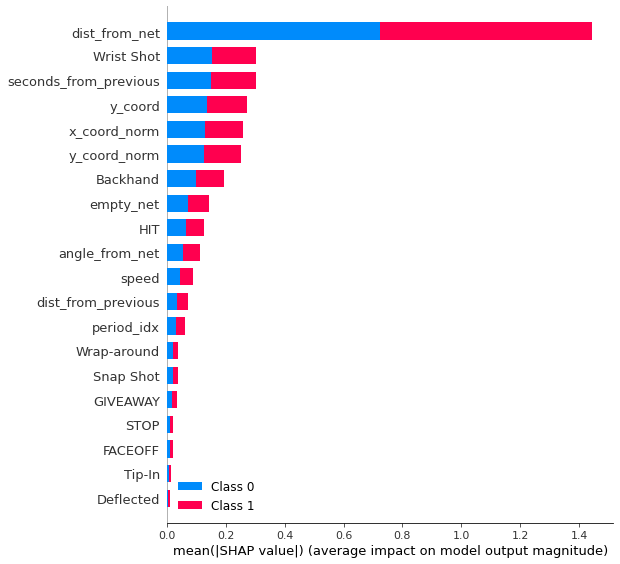

In [80]:
import shap
### Shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test[features])
shap.summary_plot(shap_values, X_test[features])

In [137]:
%%writefile best_model.py
# import comet_ml at the top of your file
from comet_ml import Experiment

# Create an experiment with your api key
experiment = Experiment(
    project_name="hockey-all-star-analytics",
    workspace="zilto",
)
path = "/Users/henaghonia/Desktop/udem/Sem-1/Data-science/Hockey-all-star-analytics/models/"

experiment.log_model("Best model-LightGBM", path+"lgbm.sav")
experiment.log_model("MLP", path+"MLP.sav")
experiment.log_model("Random forest", path+"randomForest.sav")
experiment.end()

Writing best_model.py
